# Reference envelop plots

Plots profiles reference envelop unsing PCM selection or not (as in Maze et al, 2017)

In [1]:
import xarray as xr
import numpy as np
import numpy.ma as ma
import pandas as pd

import pyxpcm
from pyxpcm.models import pcm

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import argopy
argopy.set_options(src='localftp', local_ftp='/home/coriolis_exp/spool/co05/co0508/')
argopy.set_options(mode='expert')
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()

import scipy as sp
from scipy.io import loadmat
from scipy import interpolate

import seawater as sw

from classif_functions import *

In [2]:
def get_dataow(file_path):
    
    # load from .met file
    mat_dict_load = sp.io.loadmat(file_path)
    
    #create a xarray dataset
    ds_ref = xr.Dataset(
         data_vars=dict(
             pres=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_pres']),
             ptmp=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_ptmp']),
             sal=(["n_pres", "n_profiles"], mat_dict_load['la_bhist_sal']),
         ),
         coords=dict(
             long=(["n_profiles"], np.squeeze(mat_dict_load['la_bhist_long'])),
             lat=(["n_profiles"], np.squeeze(mat_dict_load['la_bhist_lat'])),
             dates=(["n_profiles"], pd.to_datetime(list(map(str, map(int, np.squeeze(mat_dict_load['la_bhist_dates'])))))),
         ),
     )

    return ds_ref

__Input__

In [66]:
float_WMO = 4900136
prof_num = 79
ref_type = 'CTD'

## 1. Load float profile

using argopy

In [67]:
argo_loader = ArgoDataFetcher()
    
ds_f = argo_loader.profile(float_WMO, prof_num).to_xarray()
ds_f = ds_f.argo.point2profile()

In [68]:
ds_f

<xarray.Dataset>
Dimensions:                   (N_LEVELS: 70, N_PROF: 1)
Coordinates:
  * N_PROF                    (N_PROF) int64 0
  * N_LEVELS                  (N_LEVELS) int64 0 1 2 3 4 5 ... 64 65 66 67 68 69
    TIME                      (N_PROF) datetime64[ns] 2004-08-24T07:25:00
    LATITUDE                  (N_PROF) float64 39.26
    LONGITUDE                 (N_PROF) float64 -61.88
Data variables:
    CONFIG_MISSION_NUMBER     (N_PROF) int64 0
    CYCLE_NUMBER              (N_PROF) int64 79
    DATA_CENTRE               (N_PROF) <U2 'ME'
    DATA_MODE                 (N_PROF) <U1 'D'
    DATA_STATE_INDICATOR      (N_PROF) <U4 '2C+ '
    DC_REFERENCE              (N_PROF) <U32 '49001369976PF                   '
    DIRECTION                 (N_PROF) <U1 'A'
    FIRMWARE_VERSION          (N_PROF) <U32 'n/a                             '
    FLOAT_SERIAL_NO           (N_PROF) <U32 '366                             '
    PI_NAME                   (N_PROF) <U64 'Blair Greenan                   ...
    PLATFORM_NUMBER           (N_PROF) int64 4900136
    PLATFORM_TYPE             (N_PROF) <U32 'APEX-SBE                        '
    POSITIONING_SYSTEM        (N_PROF) <U8 'ARGOS   '
    POSITION_QC               (N_PROF) int64 1
    PRES                      (N_PROF, N_LEVELS) float32 9.1 19.3 ... 1999.5
    PRES_ADJUSTED             (N_PROF, N_LEVELS) float32 9.1 19.3 ... 1999.5
    PRES_ADJUSTED_ERROR       (N_PROF) float32 2.4
    PRES_ADJUSTED_QC          (N_PROF) int64 1
    PRES_QC                   (N_PROF) int64 1
    PROFILE_PRES_QC           (N_PROF) <U1 'A'
    PROFILE_PSAL_QC           (N_PROF) <U1 'A'
    PROFILE_TEMP_QC           (N_PROF) <U1 'A'
    PROJECT_NAME              (N_PROF) <U64 'Canadian Argo                   ...
    PSAL                      (N_PROF, N_LEVELS) float32 36.372 ... 34.938
    PSAL_ADJUSTED             (N_PROF, N_LEVELS) float32 36.372 ... 34.938
    PSAL_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 0.01 0.01 ... 0.01 0.01
    PSAL_ADJUSTED_QC          (N_PROF) int64 1
    PSAL_QC                   (N_PROF) int64 1
    TEMP                      (N_PROF, N_LEVELS) float32 27.123 27.126 ... 3.657
    TEMP_ADJUSTED             (N_PROF, N_LEVELS) float32 27.123 27.126 ... 3.657
    TEMP_ADJUSTED_ERROR       (N_PROF) float32 0.002
    TEMP_ADJUSTED_QC          (N_PROF) int64 1
    TEMP_QC                   (N_PROF) int64 1
    TIME_LOCATION             (N_PROF) datetime64[ns] 2004-08-24T07:25:00
    TIME_QC                   (N_PROF) int64 1
    VERTICAL_SAMPLING_SCHEME  (N_PROF) <U256 'Primary sampling: discrete     ...
    WMO_INST_TYPE             (N_PROF) int64 846
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /home/coriolis_exp/spool/co05/co0508/
    Fetched_by:           agarciaj
    Fetched_date:         2021/12/14
    Fetched_constraints:  phy;WMO4900136_CYC79
    Fetched_uri:          /home/coriolis_exp/spool/co05/co0508//dac/meds/4900...
    history:              Transformed with point2profile

In [69]:
pr = 0 # reference pressure in dbar
ds_f = ds_f.assign(ptmp=(["N_PROF", "N_LEVELS"], sw.ptmp(ds_f['PSAL'].values,ds_f['TEMP'].values,ds_f['PRES'].values,pr)))

In [70]:
ds_f

<xarray.Dataset>
Dimensions:                   (N_LEVELS: 70, N_PROF: 1)
Coordinates:
  * N_PROF                    (N_PROF) int64 0
  * N_LEVELS                  (N_LEVELS) int64 0 1 2 3 4 5 ... 64 65 66 67 68 69
    TIME                      (N_PROF) datetime64[ns] 2004-08-24T07:25:00
    LATITUDE                  (N_PROF) float64 39.26
    LONGITUDE                 (N_PROF) float64 -61.88
Data variables:
    CONFIG_MISSION_NUMBER     (N_PROF) int64 0
    CYCLE_NUMBER              (N_PROF) int64 79
    DATA_CENTRE               (N_PROF) <U2 'ME'
    DATA_MODE                 (N_PROF) <U1 'D'
    DATA_STATE_INDICATOR      (N_PROF) <U4 '2C+ '
    DC_REFERENCE              (N_PROF) <U32 '49001369976PF                   '
    DIRECTION                 (N_PROF) <U1 'A'
    FIRMWARE_VERSION          (N_PROF) <U32 'n/a                             '
    FLOAT_SERIAL_NO           (N_PROF) <U32 '366                             '
    PI_NAME                   (N_PROF) <U64 'Blair Greenan                   ...
    PLATFORM_NUMBER           (N_PROF) int64 4900136
    PLATFORM_TYPE             (N_PROF) <U32 'APEX-SBE                        '
    POSITIONING_SYSTEM        (N_PROF) <U8 'ARGOS   '
    POSITION_QC               (N_PROF) int64 1
    PRES                      (N_PROF, N_LEVELS) float32 9.1 19.3 ... 1999.5
    PRES_ADJUSTED             (N_PROF, N_LEVELS) float32 9.1 19.3 ... 1999.5
    PRES_ADJUSTED_ERROR       (N_PROF) float32 2.4
    PRES_ADJUSTED_QC          (N_PROF) int64 1
    PRES_QC                   (N_PROF) int64 1
    PROFILE_PRES_QC           (N_PROF) <U1 'A'
    PROFILE_PSAL_QC           (N_PROF) <U1 'A'
    PROFILE_TEMP_QC           (N_PROF) <U1 'A'
    PROJECT_NAME              (N_PROF) <U64 'Canadian Argo                   ...
    PSAL                      (N_PROF, N_LEVELS) float32 36.372 ... 34.938
    PSAL_ADJUSTED             (N_PROF, N_LEVELS) float32 36.372 ... 34.938
    PSAL_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 0.01 0.01 ... 0.01 0.01
    PSAL_ADJUSTED_QC          (N_PROF) int64 1
    PSAL_QC                   (N_PROF) int64 1
    TEMP                      (N_PROF, N_LEVELS) float32 27.123 27.126 ... 3.657
    TEMP_ADJUSTED             (N_PROF, N_LEVELS) float32 27.123 27.126 ... 3.657
    TEMP_ADJUSTED_ERROR       (N_PROF) float32 0.002
    TEMP_ADJUSTED_QC          (N_PROF) int64 1
    TEMP_QC                   (N_PROF) int64 1
    TIME_LOCATION             (N_PROF) datetime64[ns] 2004-08-24T07:25:00
    TIME_QC                   (N_PROF) int64 1
    VERTICAL_SAMPLING_SCHEME  (N_PROF) <U256 'Primary sampling: discrete     ...
    WMO_INST_TYPE             (N_PROF) int64 846
    ptmp                      (N_PROF, N_LEVELS) float32 27.120897 ... 3.4947073
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /home/coriolis_exp/spool/co05/co0508/
    Fetched_by:           agarciaj
    Fetched_date:         2021/12/14
    Fetched_constraints:  phy;WMO4900136_CYC79
    Fetched_uri:          /home/coriolis_exp/spool/co05/co0508//dac/meds/4900...
    history:              Transformed with point2profile

## 2. Load reference data

__data without class selection__

In [71]:
#file_path = 'mat_files/' + str(float_WMO) + '/ex_profiles/' + str(float_WMO) + '_prof' + str(prof_num) + '_refdata_' + ref_type + '_noclass.mat'
file_path = 'mat_files/' + str(float_WMO) + '/ex_profiles/' + '490136' + '_prof' + str(prof_num) + '_refdata_' + ref_type + '_noclass.mat'
ds_ref = get_dataow(file_path)
ds_ref

<xarray.Dataset>
Dimensions:  (n_pres: 2099, n_profiles: 250)
Coordinates:
    long     (n_profiles) float64 300.0 294.3 293.0 295.1 ... 301.3 302.0 307.0
    lat      (n_profiles) float64 36.09 36.15 36.54 36.19 ... 40.26 40.25 40.18
    dates    (n_profiles) datetime64[ns] 1974-01-01 1976-01-01 ... 1989-01-01
Dimensions without coordinates: n_pres, n_profiles
Data variables:
    pres     (n_pres, n_profiles) float64 9.0 7.0 8.0 15.0 ... nan nan nan nan
    ptmp     (n_pres, n_profiles) float64 26.97 20.03 18.51 18.9 ... nan nan nan
    sal      (n_pres, n_profiles) float64 36.03 36.26 36.53 34.4 ... nan nan nan

__data with class selection__

In [72]:
#file_path = 'mat_files/' + str(float_WMO) + '/ex_profiles/' + str(float_WMO) + '_prof' + str(prof_num) + '_refdata_' + ref_type + '_class.mat'
file_path = 'mat_files/' + str(float_WMO) + '/ex_profiles/' + '490136' + '_prof' + str(prof_num) + '_refdata_' + ref_type + '_class.mat'
ds_ref_class = get_dataow(file_path)
ds_ref_class

<xarray.Dataset>
Dimensions:  (n_pres: 2098, n_profiles: 128)
Coordinates:
    long     (n_profiles) float64 300.0 293.0 295.7 297.5 ... 303.9 302.0 307.0
    lat      (n_profiles) float64 36.09 36.54 38.97 34.77 ... 40.46 40.25 40.18
    dates    (n_profiles) datetime64[ns] 1974-01-01 1977-01-01 ... 1989-01-01
Dimensions without coordinates: n_pres, n_profiles
Data variables:
    pres     (n_pres, n_profiles) float64 9.0 8.0 5.0 1.0 ... nan nan nan nan
    ptmp     (n_pres, n_profiles) float64 26.97 18.51 26.76 ... nan nan nan
    sal      (n_pres, n_profiles) float64 36.03 36.53 35.97 ... nan nan nan

__data with SAF selection__

In [10]:
file_path = 'mat_files/' + str(float_WMO) + '/ex_profiles/' + str(float_WMO) + '_prof' + str(prof_num) + '_refdata_' + ref_type + '_SAF.mat'
ds_ref_saf = get_dataow(file_path)
ds_ref_saf

FileNotFoundError: [Errno 2] No such file or directory: 'mat_files/4900136/ex_profiles/4900136_prof77_refdata_argo_SAF.mat'

## 3. Plots

__Potential temperature__

NameError: name 'ds_ref_saf' is not defined

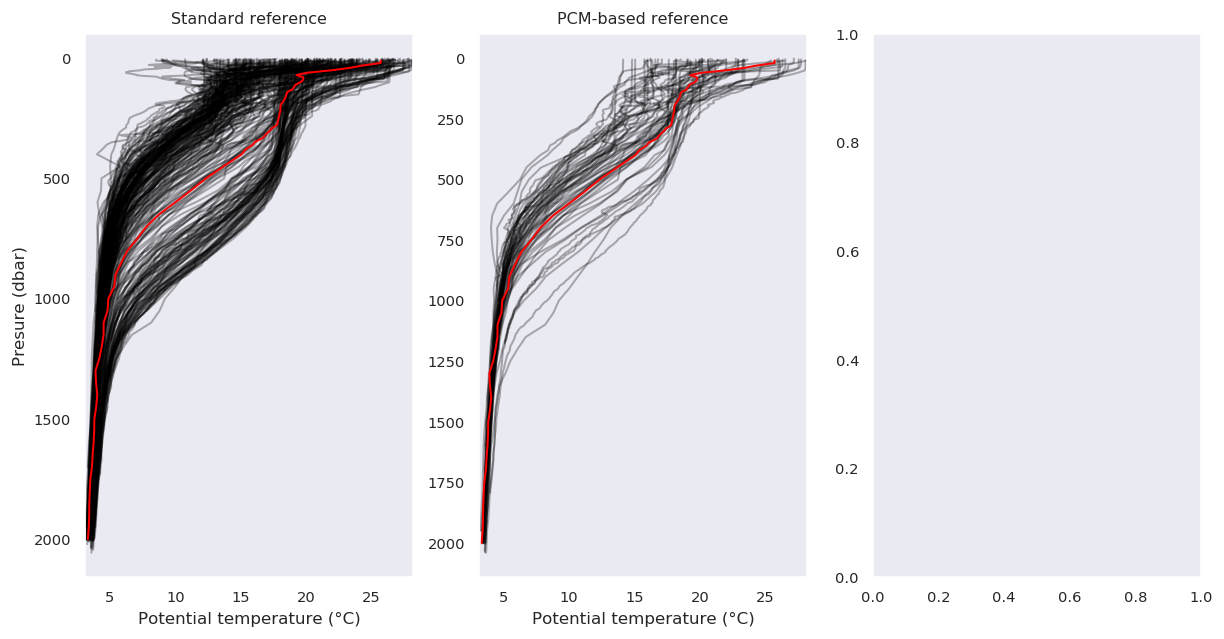

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

for i in range(len(ds_ref['n_profiles'])):
    ax[0].plot(ds_ref['ptmp'].isel(n_profiles = i), ds_ref['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[0].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[0].set_title('Standard reference')
ax[0].set_xlim([ds_ref['ptmp'].min(), ds_ref['ptmp'].max()])
#ax[0].legend()

for i in range(len(ds_ref_class['n_profiles'])):
    ax[1].plot(ds_ref_class['ptmp'].isel(n_profiles = i), ds_ref_class['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[1].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
#ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[1].set_title('PCM-based reference')
ax[1].set_xlim([ds_ref['ptmp'].min(), ds_ref['ptmp'].max()])
#ax[1].legend()

for i in range(len(ds_ref_saf['n_profiles'])):
    ax[2].plot(ds_ref_saf['ptmp'].isel(n_profiles = i), ds_ref_saf['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[2].plot(ds_f['ptmp'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[2].invert_yaxis()
ax[2].set_ylabel('Presure (dbar)', fontsize=10);
ax[2].set_xlabel('Potential temperature (°C)', fontsize=10);
ax[2].set_title('SAF reference')
ax[2].set_xlim([ds_ref['ptmp'].min(), ds_ref['ptmp'].max()])

__Salinity__

[<xarray.DataArray 'sal' ()>
array(36.8832016), <xarray.DataArray 'sal' ()>
array(32.5542984)]
[<xarray.DataArray 'sal' ()>
array(36.87659836), <xarray.DataArray 'sal' ()>
array(34.80400085)]


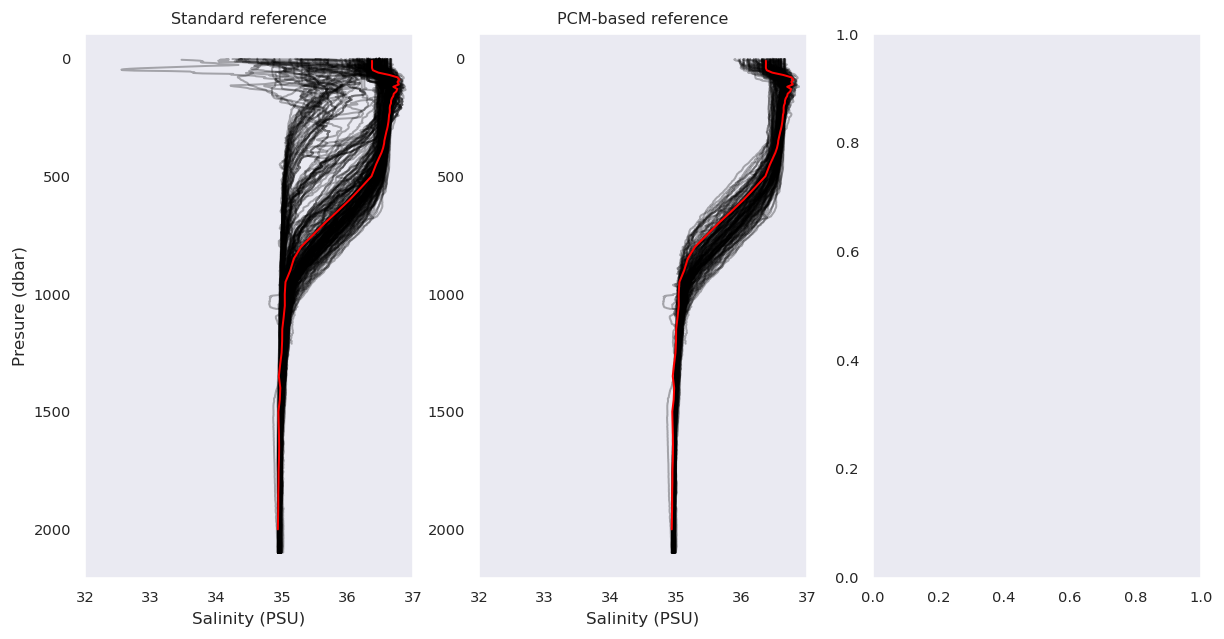

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(
            12, 6), dpi=120, facecolor='w', edgecolor='k')

for i in range(len(ds_ref['n_profiles'])):
    ax[0].plot(ds_ref['sal'].isel(n_profiles = i), ds_ref['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[0].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
#ZOOM
#ax[0].set_ylim([1400, 2000])
ax[0].invert_yaxis()
ax[0].set_ylabel('Presure (dbar)', fontsize=10);
ax[0].set_xlabel('Salinity (PSU)', fontsize=10);
ax[0].set_title('Standard reference')
#ax[0].set_xlim([ds_ref['sal'].min(), ds_ref['sal'].max()])
ax[0].set_xlim([32, 37])
#ax[0].tick_params(axis='both', which='major', labelsize=7)
print([ds_ref['sal'].max(), ds_ref['sal'].min()])

for i in range(len(ds_ref_class['n_profiles'])):
    ax[1].plot(ds_ref_class['sal'].isel(n_profiles = i), ds_ref_class['pres'].isel(n_profiles = i), 'k', alpha=0.3);
ax[1].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
ax[1].invert_yaxis()
#ax[1].set_ylabel('Presure (dbar)', fontsize=10);
ax[1].set_xlabel('Salinity (PSU)', fontsize=10);
ax[1].set_title('PCM-based reference')
#ax[1].set_xlim([ds_ref['sal'].min(), ds_ref['sal'].max()])
ax[1].set_xlim([32, 37])
#ax[1].tick_params(axis='both', which='major', labelsize=7)
#ax[1].legend()
print([ds_ref_class['sal'].max(), ds_ref_class['sal'].min()])

#for i in range(len(ds_ref_saf['n_profiles'])):
#    ax[2].plot(ds_ref_saf['sal'].isel(n_profiles = i), ds_ref_saf['pres'].isel(n_profiles = i), 'k', alpha=0.3);
#ax[2].plot(ds_f['PSAL'].values[0], ds_f['PRES'].values[0], 'r', label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO));
#ax[1].set_ylim([1400, 2000])
#ax[1].set_xlim([34.5, 35])
#ax[2].invert_yaxis()
#ax[2].set_xlabel('Salinity (PSU)', fontsize=10);
#ax[2].set_title('SAF reference')
#ax[2].set_xlim([ds_ref['sal'].min(), ds_ref['sal'].max()])

plt.savefig('figure_test.jpg', dpi=350, format='jpg')


Plot ellipses with and without class selection

In [ ]:
#selected_float_index = [i for i, isource in enumerate(ds_out['source'].values) if isource == 'selected_float']

proj=ccrs.PlateCarree()
subplot_kw = {'projection': proj}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(
            10, 6), dpi=120, facecolor='w', edgecolor='k', subplot_kw=subplot_kw)

# without class selection
p1 = ax[0].scatter(ds_ref['long'], ds_ref['lat'], s=3, transform=proj, label='Argo reference data')
p2 = ax[0].scatter(ds_f['LONGITUDE'], ds_f['LATITUDE'], s=3, color = 'r', transform=proj, label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO))

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax[0].add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax[0].gridlines(crs=ax[0].projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 10}
gl.ylabel_style = {'fontsize': 10}
gl.xlabels_top = False
gl.ylabels_right = False
ax[0].set_title('Standard reference')
long_180 = np.mod(ds_ref['long']+180,360)-180
ax[0].set_xlim([long_180.min()-0.5, long_180.max()+0.5])
ax[0].set_ylim([ds_ref['lat'].min()-0.5, ds_ref['lat'].max()+0.5])

# with class selection k=5
p1 = ax[1].scatter(ds_ref_class['long'], ds_ref_class['lat'], s=3, transform=proj, label='Argo reference data')
p2 = ax[1].scatter(ds_f['LONGITUDE'], ds_f['LATITUDE'], s=3, color = 'r', transform=proj, label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO))

land_feature = cfeature.NaturalEarthFeature(
            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
ax[1].add_feature(land_feature, edgecolor='black')

defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
gl = ax[1].gridlines(crs=ax[1].projection,draw_labels=True, **defaults)
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'fontsize': 10}
gl.ylabel_style = {'fontsize': 10}
gl.xlabels_top = False
gl.ylabels_right = False
ax[1].set_title('PCM-based reference')
ax[1].set_xlim([long_180.min()-0.5, long_180.max()+0.5])
ax[1].set_ylim([ds_ref['lat'].min()-0.5, ds_ref['lat'].max()+0.5])


# with class selection k=6
#p1 = ax[2].scatter(ds_ref_saf['long'], ds_ref_saf['lat'], s=3, transform=proj, label='Argo reference data')
#p2 = ax[2].scatter(ds_f['LONGITUDE'], ds_f['LATITUDE'], s=3, color = 'r', transform=proj, label='profile ' + str(prof_num)+ ' , float ' + str(float_WMO))

#land_feature = cfeature.NaturalEarthFeature(
#            category='physical', name='land', scale='50m', facecolor=[0.9375, 0.9375, 0.859375])
#ax[2].add_feature(land_feature, edgecolor='black')

#defaults = {'linewidth': .5, 'color': 'gray', 'alpha': 0.5, 'linestyle': '--'}
#gl = ax[2].gridlines(crs=ax[2].projection,draw_labels=True, **defaults)
#gl.xlocator = mticker.FixedLocator(np.arange(-180, 180+1, 4))
#gl.ylocator = mticker.FixedLocator(np.arange(-90, 90+1, 4))
#gl.xformatter = LONGITUDE_FORMATTER
#gl.yformatter = LATITUDE_FORMATTER
#gl.xlabel_style = {'fontsize': 5}
#gl.ylabel_style = {'fontsize': 5}
#gl.xlabels_top = False
#gl.ylabels_right = False
#ax[2].set_title('SAF reference')
#ax[2].set_xlim([long_180.min()-0.5, long_180.max()+0.5])
#ax[2].set_ylim([ds_ref['lat'].min()-0.5, ds_ref['lat'].max()+0.5])

ax[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')

### __Plot number of reference profiles per profile__

In [ ]:
# load standard reference data
file_path1 = 'mat_files/' + str(float_WMO) + '/nprof_files/' + str(float_WMO) + '_nprof_' + ref_type + '_noclass_FINAL.mat'
mat_dict = sp.io.loadmat(file_path1)
# load standard PCM based
file_path2 = 'mat_files/' + str(float_WMO) + '/nprof_files/' + str(float_WMO) + '_nprof_' + ref_type + '_class_FINAL.mat'
mat_dict_class = sp.io.loadmat(file_path2)
# load standard PCM based data k=5
file_path3 = 'mat_files/' + str(float_WMO) + '/nprof_files/' + str(float_WMO) + '_nprof_' + ref_type + '_SAF_FINAL.mat'
mat_dict_saf = sp.io.loadmat(file_path3)

In [ ]:
labels = np.arange(0,len(mat_dict['n_ref_prof'][0])+1,10)

x = np.arange(1,len(mat_dict['n_ref_prof'][0])+1)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(20, 10))
rects1 = ax.plot(x, mat_dict['n_ref_prof'][0], 'o-', label='Standard reference')
rects2 = ax.plot(x, mat_dict_class['n_ref_prof'][0], 'o-', label='PCM-based reference')
rects3 = ax.plot(x, mat_dict_saf['n_ref_prof'][0], 'o-', label='SAF reference')

ax.set_ylabel('Number of reference profiles', fontsize=25)
ax.set_xlabel('Float ' + str(float_WMO) + ' profile number', fontsize=25)
ax.set_title('Reference profiles per float profile (argo database)', fontsize=25)
ax.set_xticks(labels)
ax.set_xlim([0.5,len(mat_dict['n_ref_prof'][0])+0.5])
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=20)
ax.tick_params(axis='both', labelsize=20)